In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import pandas as pd
import matplotlib.ticker as ticker
import torch as pt
import numpy as np
from collections import defaultdict
from typing import List, Optional, Union
from Bio.PDB.Model import Model
import os
from tqdm import tqdm
from Bio import PDB
from pathlib import Path
import h5py

In [4]:
AF_path = '/home/omokhtar/Desktop/alphaflow/output/benchmarks'
AF_count = 8604
MD_count = 2954

In [19]:
# File paths
ids_path = '/home/omokhtar/Desktop/PPI/data/merged/ids.txt'
group_files = {
    'NMR': '/home/omokhtar/Desktop/ppi_model/data_analysis/NMR.txt',
    'DynaRepo': '/home/omokhtar/Desktop/ppi_model/data_analysis/DynaRepo.txt',
    'MDDB': '/home/omokhtar/Desktop/ppi_model/data_analysis/MMB.txt',
    'ATLAS': '/home/omokhtar/Desktop/ppi_model/data_analysis/Atlas.txt',
}

In [20]:
def process_groups(ids_path):
    entries = np.genfromtxt(ids_path, dtype=np.dtype('U'))
    NMR_entries = np.genfromtxt(group_files['NMR'], dtype=np.dtype('U'))
    
    group_counts = {}
    group_ratios = {}
    
    for group_name in ['MD','AF','NMR']:
        group_counts[group_name] = 0
        group_ratios[group_name] = []

    with h5py.File('/home/omokhtar/Desktop/PPI/data/merged/db_merged.h5', 'r') as r:
        for entry in tqdm(entries):
            assigned = False
            y = pt.from_numpy(np.array(r[f'data/labels/{entry}']['label']))
            label_1_count = (y == 1).sum().item()
            total_residues = len(y)
            ratio = label_1_count / total_residues if total_residues > 0 else 0
            
            if '_AF' in entry:
                group_counts['AF'] += 1
                group_ratios['AF'].append(ratio)
            else:
                if entry.split('_')[0] in NMR_entries:
                    group_counts['NMR'] += 1
                    group_ratios['NMR'].append(ratio)
                else:
                    group_counts['MD'] += 1
                    group_ratios['MD'].append(ratio)
                
    return group_counts, group_ratios

group_counts, group_ratios = process_groups(ids_path)

100%|███████████████████████████████████| 11558/11558 [00:01<00:00, 8570.00it/s]


In [21]:
print (group_ratios.keys())
print (group_counts.keys())

dict_keys(['MD', 'AF', 'NMR'])
dict_keys(['MD', 'AF', 'NMR'])


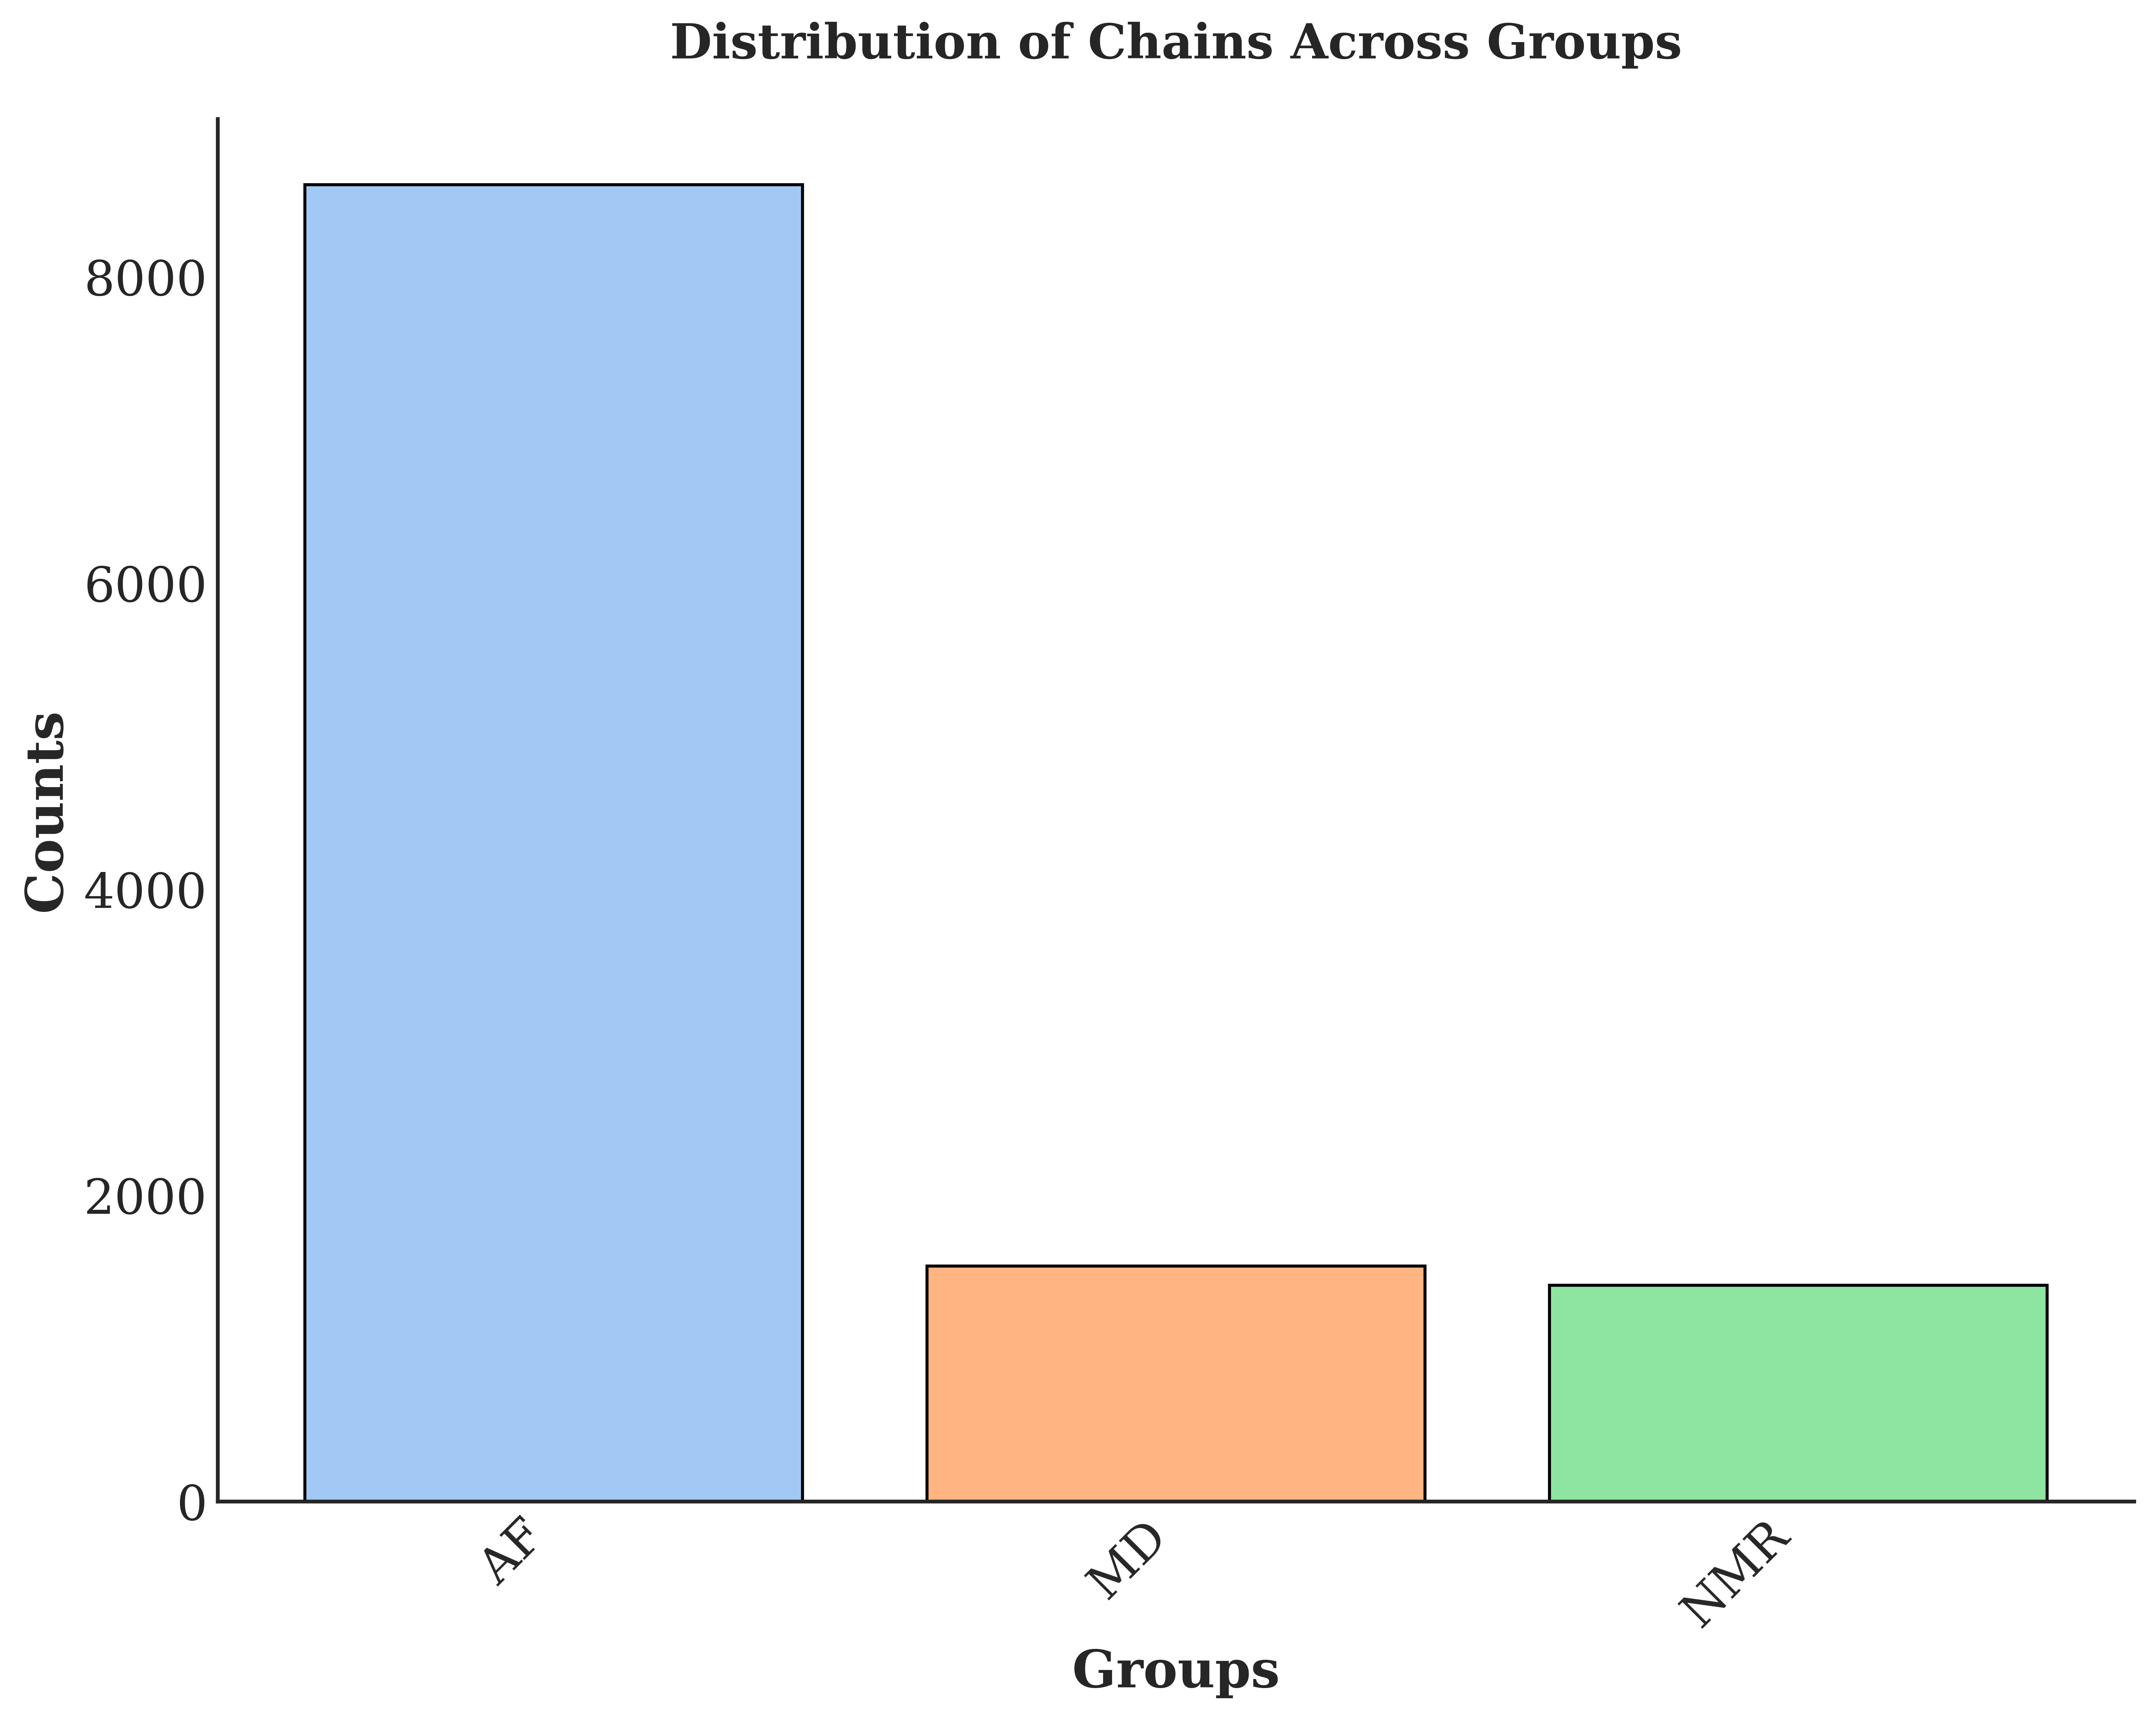

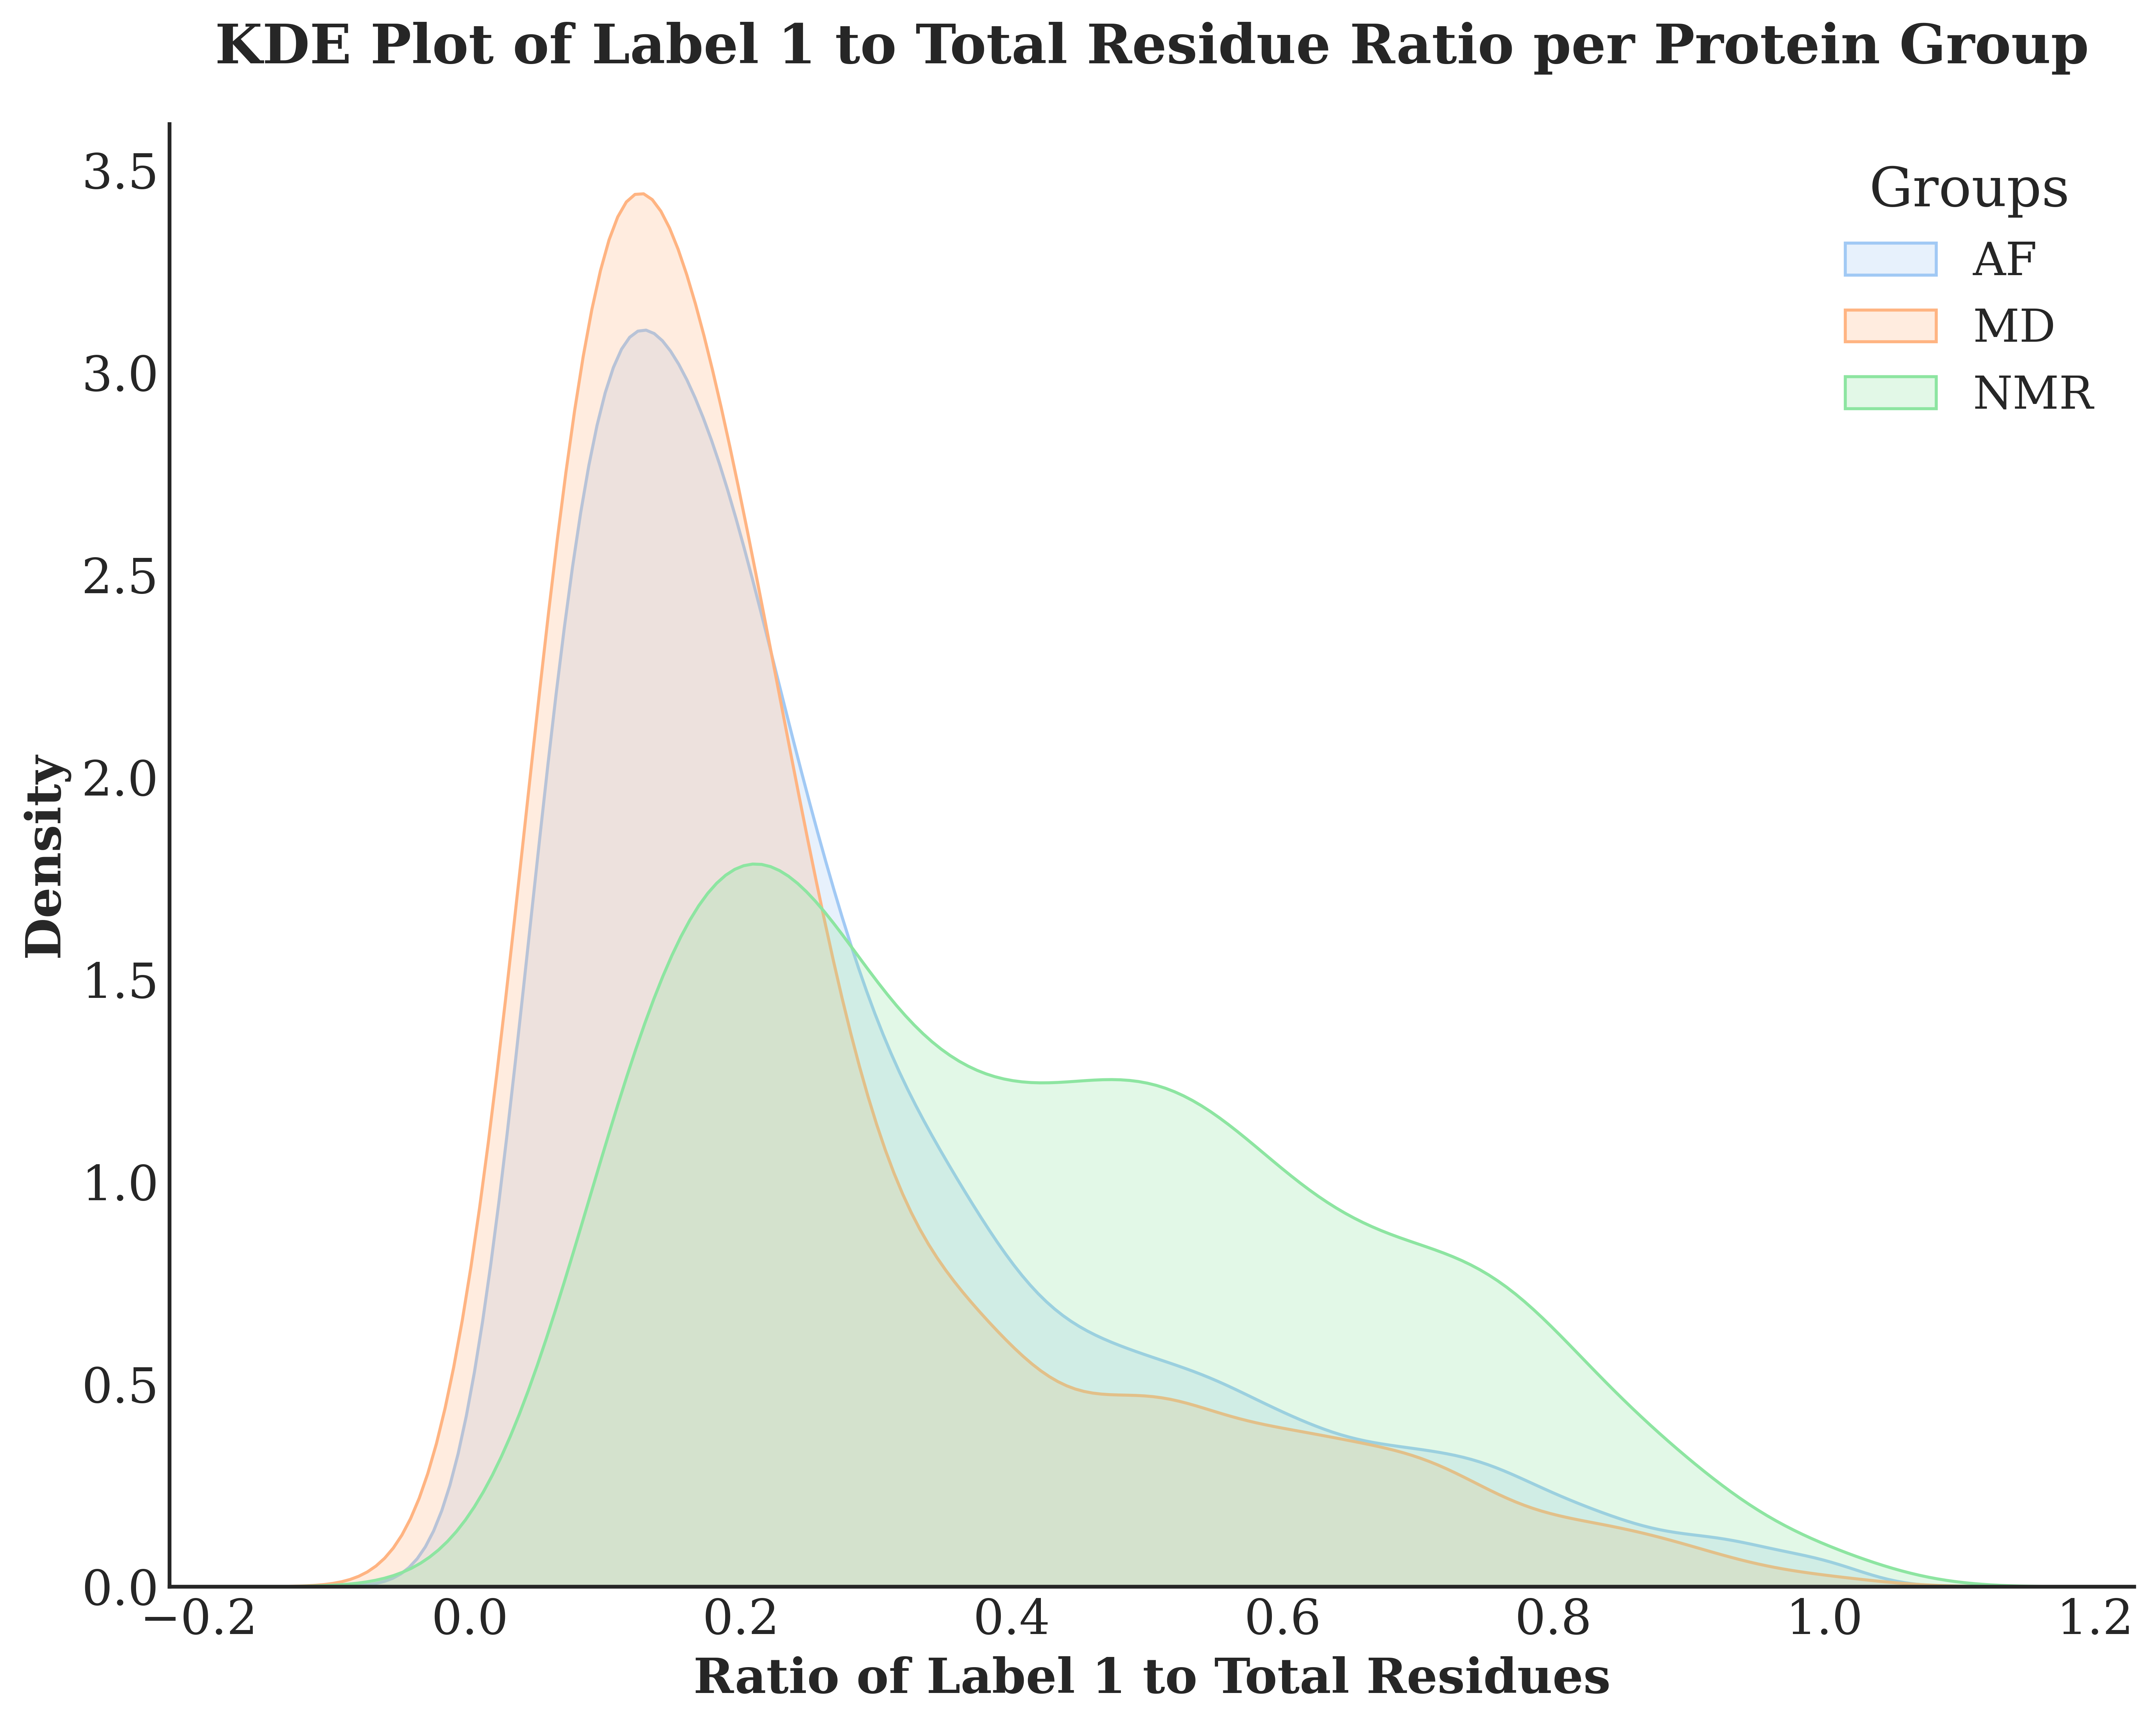

In [26]:
sorted_groups = dict(sorted(group_counts.items(), key=lambda item: item[1], reverse=True))

palette = sns.color_palette('pastel', n_colors=len(sorted_groups))

color_mapping = {group: palette[idx] for idx, group in enumerate(sorted_groups.keys())}

plt.figure(figsize=(10, 8), dpi=600)
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = 'serif'

bars = plt.bar(sorted_groups.keys(), sorted_groups.values(), color=palette, edgecolor='black')

plt.xlabel('Groups', fontsize=17, fontweight='bold')
plt.ylabel('Counts', fontsize=17, fontweight='bold')

plt.title('Distribution of Chains Across Groups', pad=20, fontsize=16, fontweight='bold')

sns.despine()
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("AF_vs_others2.svg", format="svg", transparent=True)
plt.show()

plt.figure(figsize=(10, 8), dpi=600)
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = 'serif'

for group in sorted_groups.keys():
    if group in group_ratios: 
        sns.kdeplot(group_ratios[group], fill=True, label=group, color=color_mapping[group])  # Use the mapped color

plt.xlabel('Ratio of Label 1 to Total Residues', fontsize=16, fontweight='bold')
plt.ylabel('Density', fontsize=16, fontweight='bold')

plt.title('KDE Plot of Label 1 to Total Residue Ratio per Protein Group', pad=20, fontsize=18, fontweight='bold')
plt.legend(title='Groups', title_fontsize=18, fontsize=15, frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

sns.despine()
plt.tight_layout()
plt.savefig("AF_vs_others.svg", format="svg", transparent=True)
plt.show()

In [28]:
def calculate_rmsf(models: List[Model]) -> Optional[float]:
    residue_coords = defaultdict(list)
    
    n_models = len(models)
    for model in models:
        for chain in model.get_chains():
            for residue in chain:
                if 'CA' in residue:
                    res_id = (chain.id, residue.id[1])  # Use chain ID and residue number as key
                    residue_coords[res_id].append(residue['CA'].get_coord())
    
    if not residue_coords:
        return None
    
    complete_residues = {k: v for k, v in residue_coords.items() if len(v) == n_models}
    if not complete_residues:
        return None
    
    coords_array = np.array([coords for coords in complete_residues.values()])
    coords_array = coords_array.transpose(1, 0, 2)  # Reshape to desired format
    
    mean_structure = np.mean(coords_array, axis=0)
    diff_sq = np.sum((coords_array - mean_structure) ** 2, axis=2)
    rmsf = np.sqrt(np.mean(diff_sq, axis=0))
    
    return float(np.mean(rmsf))

def process_pdb_folder(folder_path):
    parser = PDB.PDBParser(QUIET=True)
    rmsf_values = []
    print (folder_path)
    for pdb_file in tqdm(Path(folder_path).glob('*.pdb')):
        try:
            structure = parser.get_structure('temp', pdb_file)
            models = list(structure.get_models())
            if len(models) > 1:  # Only process files with multiple models
                mean_rmsf = calculate_rmsf(models)
                if mean_rmsf is not None:
                    rmsf_values.append(mean_rmsf)
        except Exception as e:
            print(f"Error processing {pdb_file}: {e}")
    return rmsf_values

folders = {
    
    #'DynRepo': '/media/omokhtar/Expansion/Omid/ppi_model/data/DynRepo',
    #'NMR': '/media/omokhtar/Expansion/Omid/ppi_model/data/NMR_realigned',
    #'MMB': '/media/omokhtar/Expansion/Omid/ppi_model/data/MMB',
    #'Atlas': '/media/omokhtar/Expansion/Omid/ppi_model/data/Atlas',
    #'AlphaFlow': '/media/omokhtar/Expansion/Omid/AlphaFlow/not_raw/training_extended2',
}

# Process all folders and create a DataFrame
data = []
for group, folder in folders.items():
    rmsf_values = process_pdb_folder(folder)
    data.extend([(group, rmsf) for rmsf in rmsf_values])

/media/omokhtar/Expansion/Omid/AlphaFlow/not_raw/training_extended2


2226it [09:12,  4.03it/s]


In [35]:
#df = pd.DataFrame(data, columns=['Group', 'RMSF'])

# Save the DataFrame to a CSV file
#df.to_csv('/home/omokhtar/Desktop/ppi_model/data_analysis/rmsf_data2.csv', index=False)

# Read the file:
df = pd.read_csv('/home/omokhtar/Desktop/ppi_model/data_analysis/rmsf_data.csv')

df

,Group,RMSF
0,AlphaFlow,2.168792
1,AlphaFlow,1.069797
2,AlphaFlow,12.778471
3,AlphaFlow,7.367764
4,AlphaFlow,5.352097
...,...,...
5500,Atlas,2.402469
5501,Atlas,0.793679
5502,Atlas,1.538408
5503,Atlas,2.225322


In [37]:
sorted_groups

{'AF': 8604, 'MD': 1540, 'NMR': 1414}

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

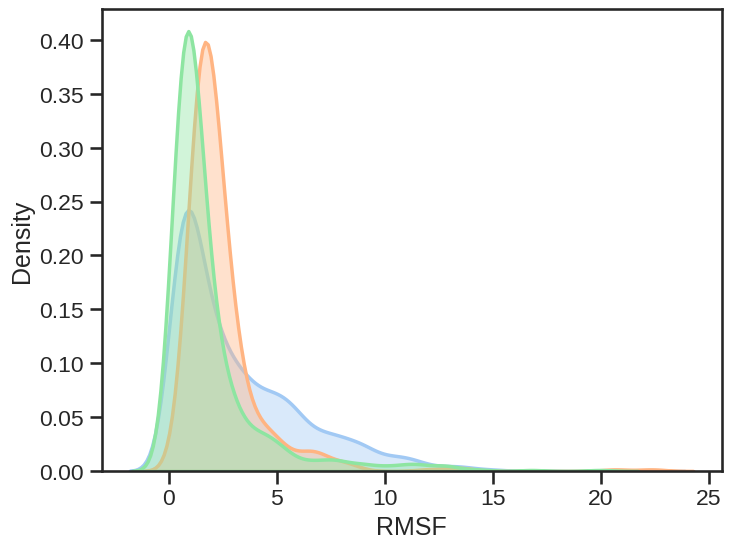

In [38]:
plt.clf()

plt.figure(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.set_context("talk")

sorted_groups = dict(sorted(group_counts.items(), key=lambda item: item[1], reverse=True))
palette = sns.color_palette('pastel', n_colors=len(sorted_groups))

for i, group in enumerate(df['Group'].unique()):
    group_data = df[df['Group'] == group]['RMSF']
    sns.kdeplot(data=group_data, 
                label=group, 
                fill=True, 
                color=palette[i],
                alpha=0.4, 
                linewidth=2.5)

plt.title('Comparison of RMSF Distributions Across Groups', 
          fontsize=16, 
          fontweight='bold', 
          pad=20)

plt.xlabel('RMSF (Å)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(0, 6)
plt.ylim(0, 1)
plt.legend(title='Group', 
          title_fontsize=12,
          fontsize=10,
          loc='upper right',
          frameon=True)
plt.grid(False)
plt.tight_layout()
plt.savefig("rmsf_comparison_by_data_group.svg", format="svg")

/tmp/ipykernel_275617/4214402313.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df,
/tmp/ipykernel_275617/4214402313.py:18: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.violinplot(data=df,
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


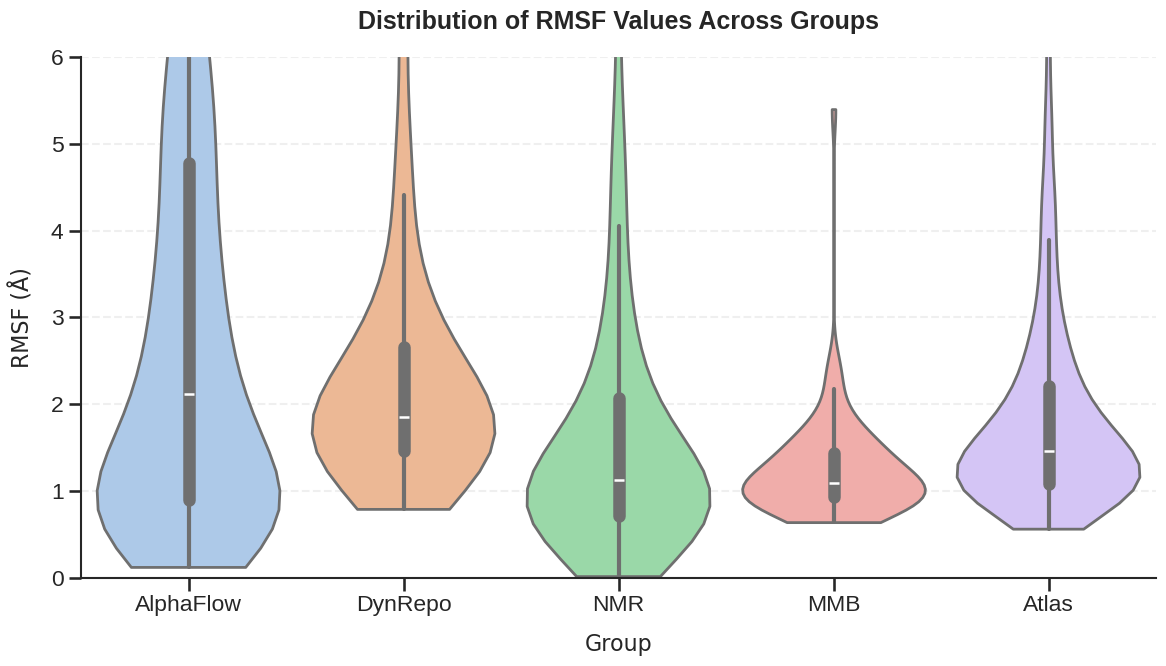

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.clf()

plt.figure(figsize=(12, 7))
plt.style.use('seaborn-v0_8-white')
sns.set_context("talk")

sorted_groups = dict(sorted(group_counts.items(), key=lambda item: item[1], reverse=True))
palette = sns.color_palette('pastel') #, n_colors=len(sorted_groups)

sns.violinplot(data=df, 
               x='Group', 
               y='RMSF',
               palette=palette,
               inner='box',  
               cut=0,   
               linewidth=2,  
               saturation=0.7,
               width=0.85)        

plt.title('Distribution of RMSF Values Across Groups', 
         fontsize=18, 
         fontweight='bold', 
         pad=20,)

plt.xlabel('Group', fontsize=16, font='Arial', labelpad=12)
plt.ylabel('RMSF (Å)', fontsize=16, font='Arial', labelpad=12)

plt.ylim(0, 6)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

plt.savefig("rmsf_violin_plot_enhanced2.svg", 
            format="svg", 
            bbox_inches='tight', 
            dpi=600,
            transparent=True)